In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')
from meta_learning import evaluator
from sklearn.metrics import mean_squared_error

from utils import DATASETS_METADATA, MODELS_METADATA

In [17]:
def get_n_features(dataset_name: str):
    filename = f"../models/basemodel: DecisionTreeClassifier - metric: kappa - dataset: {dataset_name} - with_drift_metrics.pickle"
    with open(filename, 'rb') as handle:
        model = pickle.load(handle)
    return model.n_features_

In [35]:

COLORS = [
    "#eb5600ff", # orange
    "#1a9988ff", # green
    "#595959ff", # grey
    "#6aa4c8ff", # blue
    "#f1c232ff", # yellow
    ]

FINAL_FEATURE_FRACTION = {'powersupply': 50, 'airlines': 65, 'electricity': 15, 'rialto': 10}

N_FEATURES_DICT = {}
for dataset_name in DATASETS_METADATA.keys():
    N_FEATURES_DICT[dataset_name] = get_n_features(dataset_name)

FINAL_N_FEATURES = {dataset_name: int(np.ceil(N_FEATURES_DICT[dataset_name] * FINAL_FEATURE_FRACTION[dataset_name] / 100)) for dataset_name in N_FEATURES_DICT.keys()}
FINAL_N_FEATURES

{'powersupply': 533, 'airlines': 129, 'electricity': 24, 'rialto': 129}

In [19]:
result_df = pd.DataFrame()

for dataset_name, dataset_metadata in DATASETS_METADATA.items():
    for base_model in MODELS_METADATA.keys():
        for feature_perc in range(5, 101, 5):
            filename = f"results_dataframes/base_model: {base_model} - dataset: {dataset_name} - select_k_features: {feature_perc}%.csv"
            this_df = pd.read_csv(filename).dropna()
            this_df["base_model"] = base_model
            this_df["feature_perc"] = feature_perc
            this_df["dataset_name"] = dataset_name
            this_df["original_n_features"] = N_FEATURES_DICT[dataset_name]
            this_df["final_n_features"] = int(np.ceil(N_FEATURES_DICT[dataset_name] * feature_perc / 100))
            result_df = pd.concat([result_df, this_df], ignore_index=True)

In [20]:
result_df.head()

,precision,recall,kappa,f1-score,last_precision,last_recall,last_kappa,last_f1-score,precision_pred_0_with_drift,precision_pred_0_without_drift,...,f1-score_pred_0_without_drift,base_model,feature_perc,dataset_name,original_n_features,final_n_features,auc,last_auc,auc_pred_0_with_drift,auc_pred_0_without_drift
0,0.14,0.14,0.104167,0.14,0.11,0.11,0.072917,0.11,0.166929,0.143031,...,0.143031,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
1,0.12,0.12,0.083142,0.12,0.11,0.11,0.072917,0.11,0.111111,0.068375,...,0.068375,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
2,0.08,0.08,0.038261,0.08,0.11,0.11,0.072917,0.11,0.107524,0.072585,...,0.072585,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
3,0.04,0.04,0.000000,0.04,0.11,0.11,0.072917,0.11,0.097371,0.054341,...,0.054341,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
4,0.03,0.03,0.000000,0.03,0.11,0.11,0.072917,0.11,0.106608,0.027877,...,0.027877,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN


In [21]:

class FeatureCountPlotter():
    def __init__(self, group_col: str="feature_perc", dataset_col="dataset_name", base_model_col="base_model"):
        self.group_col = group_col
        self.dataset_col = dataset_col
        self.base_model_col = base_model_col
        self.metrics = list(set(result_df.columns).intersection(set(evaluator.binary_clf_metrics)))

    def fit(self):
        group_values = result_df[self.group_col].unique()
        datasets = result_df[self.dataset_col].unique()
        base_models = result_df[self.base_model_col].unique()

        results = pd.DataFrame(columns=[
            "metric",
            self.group_col,
            self.base_model_col,
            self.dataset_col,
            "baseline_mse",
            "proposed_mtl_mse",
            "original_mtl_mse",
        ])

        for group in group_values:
            for dataset in datasets:
                for base_model in base_models:
                    df = result_df[
                        (result_df[self.group_col] == group) &
                        (result_df[self.dataset_col] == dataset) &
                        (result_df[self.base_model_col] == base_model)]

                    if df.shape[0]:
                        for metric in self.metrics:
                            results.loc[len(results)] = {
                                "metric": metric,
                                self.group_col: group,
                                self.dataset_col: dataset,
                                self.base_model_col: base_model,
                                "baseline_mse": mean_squared_error(df[metric], df[f"last_{metric}"]),
                                "proposed_mtl_mse": mean_squared_error(df[metric], df[f"{metric}_pred_0_with_drift"]),
                                "original_mtl_mse": mean_squared_error(df[metric], df[f"{metric}_pred_0_without_drift"]),
                            }
        self.summarized_df = results.set_index(self.group_col)
        return self

    def plot(self, title: str="", multiple_lines_col="metric", filter_col="dataset_name", ref_line_dict: dict=None, plot_legend=True):
        fig = plt.figure(figsize=(25, 5))
        fig.suptitle(title, fontsize=25)
        cols = ["proposed_mtl_mse", multiple_lines_col]

        for idx, filter_val in enumerate(self.summarized_df[filter_col].unique()):
            df_plot = self.summarized_df[self.summarized_df[filter_col] == filter_val][cols]
            df_plot = df_plot.groupby([self.group_col, multiple_lines_col]).sum().reset_index()
            df_plot = df_plot.pivot(values="proposed_mtl_mse", columns=multiple_lines_col, index=self.group_col)
            ax = fig.add_subplot(int(f"14{idx+1}"))
            df_plot.plot(color=COLORS, lw=2, ax=ax, legend=plot_legend)
            if ref_line_dict:
                ax.axvline(ref_line_dict[filter_val], color='r', linestyle='--')
            plt.title(filter_val, fontsize=20)

# Number of features results

In [22]:
group_col = "final_n_features"
n_feat_plotter = FeatureCountPlotter(group_col)
n_feat_plotter.fit()

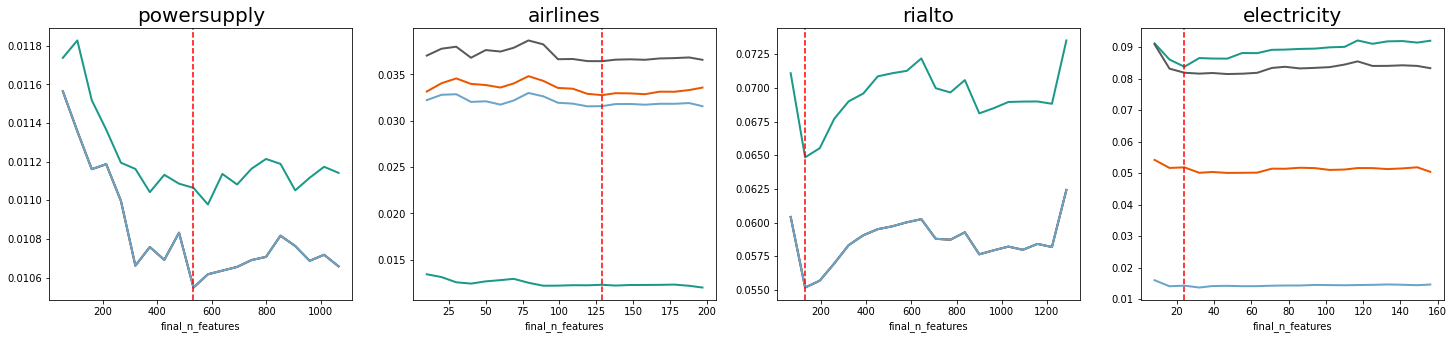

In [36]:
n_feat_plotter.plot(multiple_lines_col="metric", filter_col = "dataset_name", ref_line_dict=FINAL_N_FEATURES, plot_legend=False)

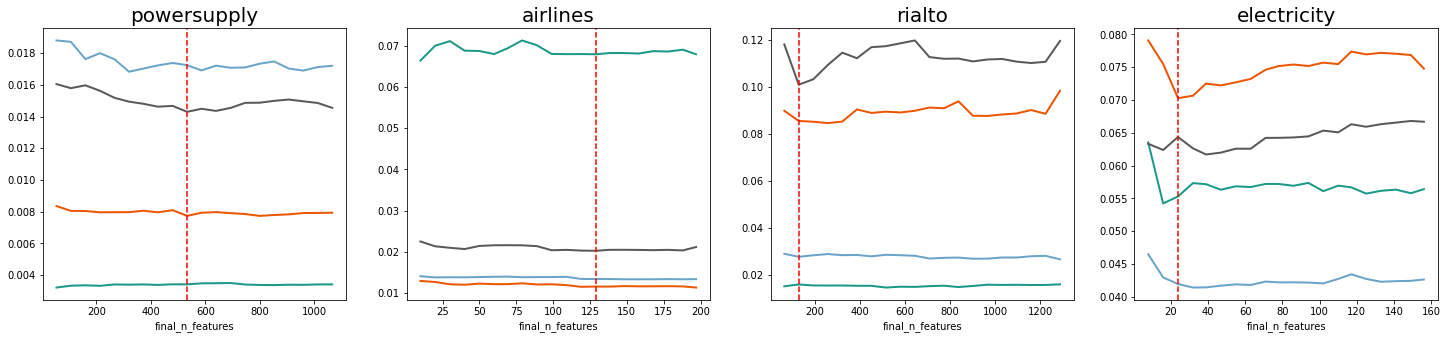

In [37]:
n_feat_plotter.plot(multiple_lines_col="base_model", filter_col = "dataset_name", ref_line_dict=FINAL_N_FEATURES, plot_legend=False)

# Feature fraction results

In [25]:
group_col = "feature_perc"
plotter = FeatureCountPlotter(group_col)
plotter.fit()

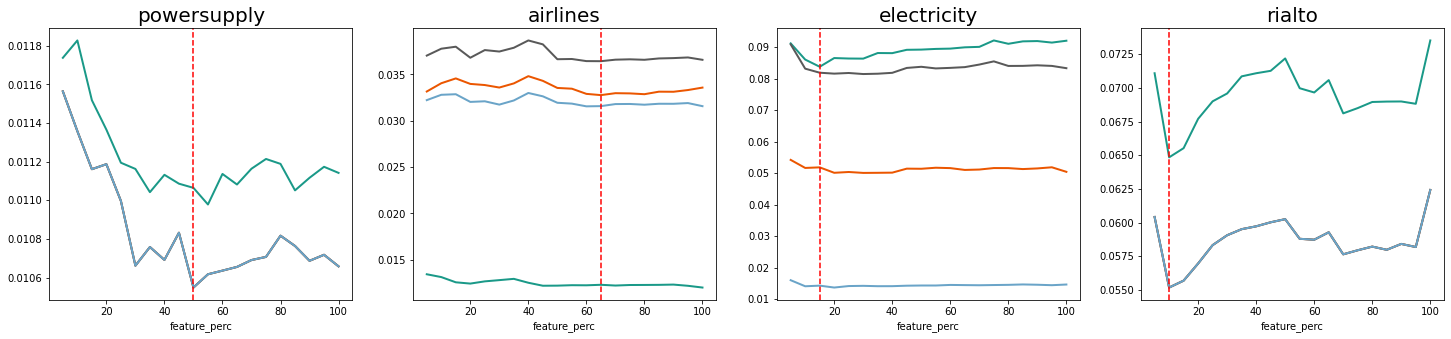

In [38]:
plotter.plot(multiple_lines_col="metric", filter_col = "dataset_name", ref_line_dict=FINAL_FEATURE_FRACTION, plot_legend=False)

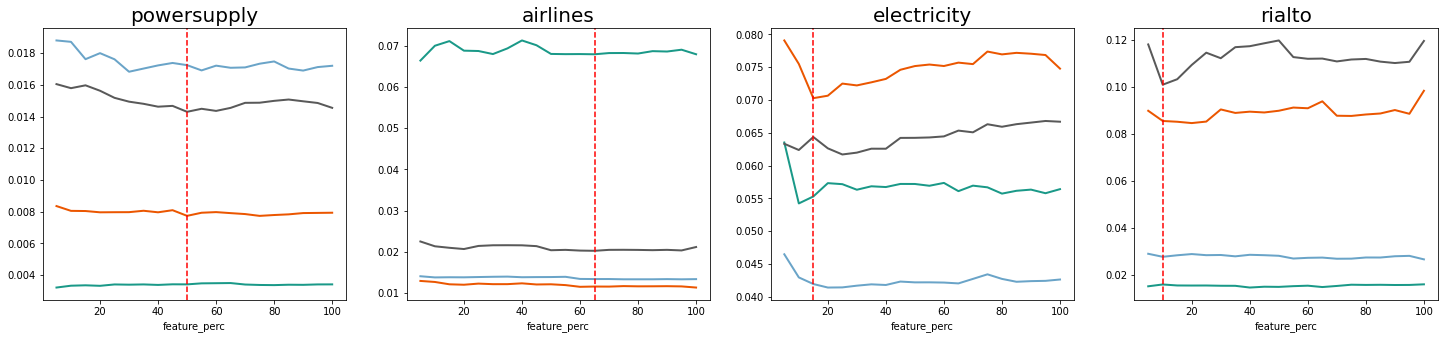

In [39]:
plotter.plot(multiple_lines_col="base_model", filter_col = "dataset_name", ref_line_dict=FINAL_FEATURE_FRACTION, plot_legend=False)

# Get feature fraction with min error

In [34]:
def get_min_mse(dataset_name):
    df = plotter.summarized_df[plotter.summarized_df["dataset_name"] == dataset_name]["proposed_mtl_mse"]
    return df.groupby([plotter.group_col]).sum().reset_index().sort_values("proposed_mtl_mse")["feature_perc"].head(1).values[0]


FINAL_FEATURE_FRACTION = {}
for dataset_name in DATASETS_METADATA.keys():
    FINAL_FEATURE_FRACTION[dataset_name] = get_min_mse(dataset_name)
FINAL_FEATURE_FRACTION

{'powersupply': 50, 'airlines': 65, 'electricity': 15, 'rialto': 10}